# turbpy package for simulating sensible and latent heat fluxes
- Provide boundary conditions to specified stability functions
- Allows direct testing of turbulence stability schemes

In [1]:
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# -------------------------------------------------------------------------------------------------------
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xray
from scipy.stats.stats import pearsonr

# -------------------------------------------------------------------------------------------------------
# OS interaction
import sys, pickle, os

# -------------------------------------------------------------------------------------------------------
# plotting packages
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('paper')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# -------------------------------------------------------------------------------------------------------
# Custom packages
import solargeo
import kgraph
import turbpy
import turbpy.multiConst as mc

# -------------------------------------------------------------------------------------------------------
# Directory Lists
# -------------------------------------------------------------------------------------------------------
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

dirProj = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/'  # Project directory
dirPrint = dir_pre+'SnowHydrology/proj/TurbulenceFeedbacks/Graphics'  # Directory for printing figures

### Check behavior of stability functions


In [2]:
ixStability = ('standard', 'louisInversePower', 'mahrtExponential', 'moninObukhov')
sfcTemp = 265
airTemp = np.arange(253, 293)
windspd = 1.
mHeight = 2.
z0Ground = .005
snowDepth = 0.
scalarGroundSnowFraction  = 1.
(airVaporPress, _) = turbpy.satVapPress(airTemp - 273.)
(sfcVaporPress, _) = turbpy.satVapPress(sfcTemp - 273.)
airPressure = 101000.

RiBulk,_,_ = turbpy.bulkRichardson(airTemp, sfcTemp, windspd, mHeight)

## Test Stability Functions

In [3]:
## Calculate stability
stabilitySchemes = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk),
    ixStability[3]:np.zeros_like(RiBulk),
    }
conductanceSensible = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk),
    ixStability[3]:np.zeros_like(RiBulk),
    }
conductanceLatent = {
    ixStability[0]:np.zeros_like(RiBulk),
    ixStability[1]:np.zeros_like(RiBulk),
    ixStability[2]:np.zeros_like(RiBulk),
    ixStability[3]:np.zeros_like(RiBulk),
    }

for stab in stabilitySchemes:
    for n,(tair,vp) in enumerate(zip(airTemp, airVaporPress)):
        (_,stabOutput,_,
         conductanceSensible[stab][n],
         conductanceLatent[stab][n]) = turbpy.aStability(False, stab, mc.stabParams[stab], mHeight, tair,
               vp, sfcTemp, sfcVaporPress, windspd, z0Ground)
        if not 'moninObukhov' in stab:
            stabilitySchemes[stab][n] = stabOutput['stabilityCorrection']

0.2


TypeError: 'float' object is not subscriptable

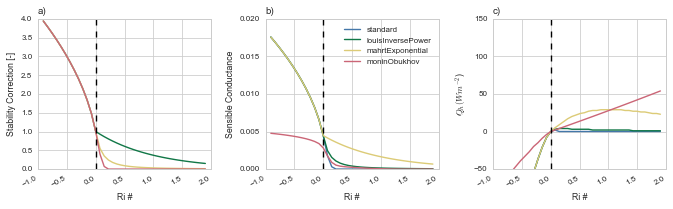

In [10]:
colr = kgraph.SRON(4)
fig, axes = plt.subplots(1,3,figsize=(9.5, 3))
axes = axes.flatten()

# Stability correction
ax = axes[0]
for n, stab in enumerate(stabilitySchemes):
    if stab == 'moninObukhov':
        continue
    ax.plot(RiBulk, stabilitySchemes[stab], label=stab, color=colr[n])
ax.plot([0,0],[0, 4], 'k--')
ax.set_ylabel('Stability Correction [-]')
ax.set_xlabel('Ri #')
ax.set_title('a)', loc='left')

# Conductance
ax = axes[1]
for n,stab in enumerate(ixStability):
    ax.plot(RiBulk, conductanceSensible[stab], label=stab, color=colr[n])
ax.plot([0, 0], [0., 0.02], 'k--')
ax.legend(loc='best')
ax.set_ylim(0,0.02)
ax.set_ylabel('Sensible Conductance')
ax.set_xlabel('Ri #')
ax.set_title('b)', loc='left')


# Sensible Heat Flux
# Plotting parameters
Qmax = 150
Qmin = -50
RiMax = 4
RiMin = -.1

# Bulk Richardson number
RiBulk,_,_ = turbpy.bulkRichardson(airTemp,sfcTemp,windspd,mHeight)
ax = axes[2]

for sindex, stab in enumerate(ixStability):
    senHeatGround = np.zeros_like(airTemp)
    latHeatGround = np.zeros_like(airTemp)

    for n,(tair, vp) in enumerate(zip(airTemp, airVaporPress)):
        (_, _, senHeatGround[n], latHeatGround[n], _, _, _, _) = turbpy.turbFluxes(
            tair, airPressure, vp, windspd, sfcTemp, sfcVaporPress, snowDepth, mHeight,
            groundSnowFraction=1, ixDerivMethod=False, ixStability=stab,
            ixStabParam=mc.stabParams[stab], z0Ground=.005,
            )

    ax.plot(RiBulk, senHeatGround, color=colr[sindex])
ax.plot([0, 0], [Qmin, Qmax], 'k--')
ax.set_ylim(Qmin, Qmax)
ax.set_xlabel('Ri #')
ax.set_ylabel('$Q_h (Wm^{-2}$)')
ax.set_title('c)', loc='left')
    
fig.tight_layout()
fig.autofmt_xdate()
os.chdir(dirPrint)
fig.savefig('TF.OfflineTurb.Idealized.pdf')

Example of the stability functions available in the turbpy package.

a) The stability corrections for the bulk aerodynamic methods

b) the conductance for all methods

c) the resulting sensible heat fluxes for each method assuming a surface temperature of 265K, wind speed of 1 m/s, 
surface roughness of 0.005, and varying the air temperature from 253K (Ri = -1) to 293K (Ri = 2).
